# NDVI Quicklooks & Analysis

# Check Shapefile Content 

### Import Dependencies

In [ ]:
# Call the functions script
#from functions import mask_data, convert

#import functions as fn

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

from cartopy import crs, feature
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import geopandas as gpd
from matplotlib.gridspec import GridSpec

In [2]:
def mask_data(data, shapefile):
    try:
        import geopandas as gpd
        import xarray as xr
        from rasterio import features
    except:
        !pip install xarray numpy geopandas rasterio --quiet
        
        import geopandas as gpd
        import xarray as xr
        from rasterio import features
        
    # Read the shapefile using geopandas
    gdf = gpd.read_file(shapefile)
    
    # Create a list of shape geometries from the GeoDataFrame
    shapes = [(geom, 1) for geom in gdf.geometry]

    # Use rasterio.features.geometry_mask to create a mask based on the shapefile
    d_shape = data[0].shape if len(data.shape)>2 else data.shape
    mask = features.geometry_mask(shapes, out_shape=d_shape, 
                                  transform=data.rio.transform(), invert=True)

    # Apply the mask to the data
    masked_data = data.where(mask)
    return masked_data


def plot_additions(ax=None):
    from cartopy import crs
    ax.coastlines()
    ax.add_feature(feature.BORDERS, linewidth=.5, linestyle='--')
    gdf.plot(ax=ax, facecolor='none', edgecolor='blue', transform=crs.PlateCarree(), zorder=5)
    gl = ax.gridlines(crs=crs.PlateCarree(), draw_labels=True, linewidth=0, color='k', alpha=0.25, linestyle='--')
    gl.right_labels = False ; gl.top_labels = False


# Load NetCDF Data and Shapefile

In [4]:
pwd

'/home/jovyan/shared-public/Hesperosaurus_Bon_Fortepiano/James'

In [5]:
shapefile = "/home/jovyan/shared-public/Hesperosaurus_Bon_Fortepiano/data_dir/shape_files.CRREBaC_CRB/CRREBaC_CRB_L1.shp"
shapefile2 = "/home/jovyan/shared-public/Hesperosaurus_Bon_Fortepiano/data_dir/shape_files.Aqueduct_river_basins_CONGO/Aqueduct_river_basins_CONGO.shp"
NDVI_file = "/home/jovyan/shared-public/Hesperosaurus_Bon_Fortepiano/data_dir/vegetation-data/NDVI_*_congo_river_basin.nc"

ds = xr.open_mfdataset(NDVI_file, combine="nested", concat_dim="time")#.load()
#da_ndvi = ds.NDVI
gdf = gpd.read_file(shapefile)


# Quality Control the NDVI data

In [6]:
# define a function to extract high quality NDVI data
def get_quality_info(data, QA_var='QA'):
    """
    QA: the QA value read in from the NDVI data

    High quality NDVI should meet the following criteria:
    Bit 7: 1 (All AVHRR channels have valid values)
    Bit 2: 0 (The pixel is not covered by cloud shadow)
    Bit 1: 0 (The pixel is not covered by cloud)

    Output:
    True: high quality
    False: low quality
    """
    try:
        QA = data[QA_var]
    except:
        QA = QA_var
    # unpack quality assurance flag for cloud (byte: 1)
    cld_flag = (QA % (2**2)) // 2
    # unpack quality assurance flag for cloud shadow (byte: 2)
    cld_shadow = (QA % (2**3)) // 2**2
    # unpack quality assurance flag for AVHRR values (byte: 7)
    value_valid = (QA % (2**8)) // 2**7

    mask = (cld_flag == 0) & (cld_shadow == 0) & (value_valid == 1)

    qc_data = data.where(mask)
    return qc_data

In [7]:
da_ndvi = get_quality_info(ds, QA_var='QA').NDVI

# Mask Data 

In [8]:
masked_data_CongoRiverBasin = mask_data(da_ndvi, shapefile)
masked_data_CongoRiverBasin.attrs = da_ndvi.attrs #.long_name
mask_mean = masked_data_CongoRiverBasin.mean('time')

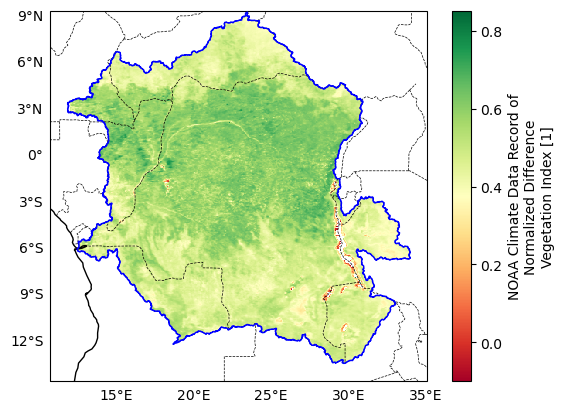

In [10]:
fig, ax = plt.subplots(subplot_kw={'projection':crs.PlateCarree()})

mask_mean.attrs = da_ndvi.attrs
mask_mean.plot(ax=ax, vmax=.85, vmin=-0.1, cmap='RdYlGn', transform=crs.PlateCarree())

plot_additions(ax=ax)
plt.savefig('/home/jovyan/shared-public/Hesperosaurus_Bon_Fortepiano/quicklook_outputs/NDVI/sample_masked_ndvi_output.png', dpi=300)

# Spatial & Temporal Plots

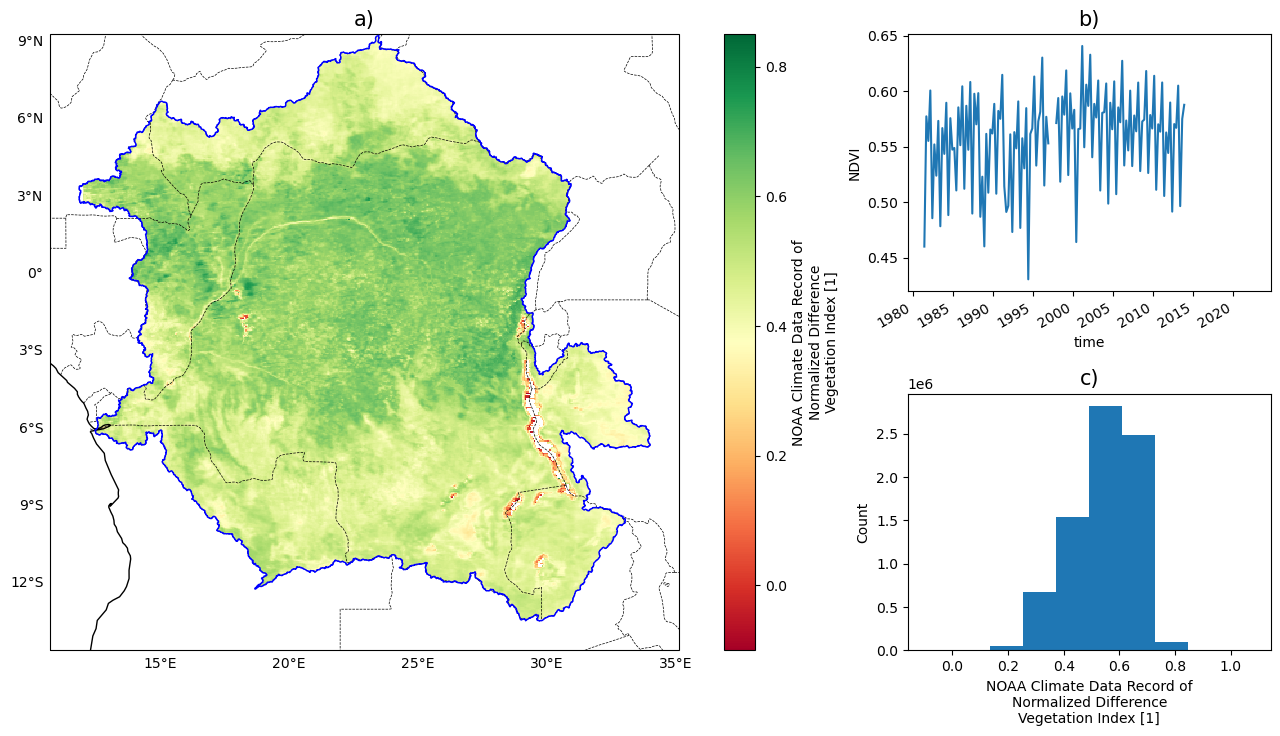

In [12]:
fig = plt.figure(figsize=(17,8))
plt.subplots_adjust(hspace=0.4, wspace=0.075)
# Create a 2x2 grid
grid = GridSpec(2, 2, width_ratios=[5, 2], height_ratios=[1, 1])

ax = plt.subplot(grid[:, 0], projection=crs.PlateCarree())
mask_mean.plot(ax=ax, vmax=.85, vmin=-0.1, cmap='RdYlGn')#, transform=crs.PlateCarree())
plot_additions(ax=ax)
ax.set_title('a)', fontsize=15)


ax = plt.subplot(grid[0, 1])
#masked_data_CongoRiverBasin.groupby('time.year').mean(['time','latitude','longitude']).plot(ax=ax)
masked_data_CongoRiverBasin.resample(time='3MS').mean('time').mean(
    ['longitude','latitude']).plot(ax=ax)
ax.set_title('b)', fontsize=15)


ax = plt.subplot(grid[1, 1])
masked_data_CongoRiverBasin.resample(time='6MS').mean('time').plot(ax=ax)
ax.set_ylabel('Count')
ax.set_title('c)', fontsize=15)
plt.savefig('/home/jovyan/shared-public/Hesperosaurus_Bon_Fortepiano/quicklook_outputs/NDVI/sample_masked_ndvi_output.png', dpi=300)